## Download Modules

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json
s = json.load(open('../style/bmh_matplotlibrc.json'))
matplotlib.rcParams.update(s)
matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 5000

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# まずsleep_dataをダウンロード、そして可視化

In [2]:
# Data formatted in different notebook
sleep_data = pd.read_csv('sleep_data.csv')

# Labels for plotting
sleep_labels = ['23:00', '23:30', '00:00', '00:30', '01:00', '01:30', '02:00', '02:30', '03:00', '03:30']

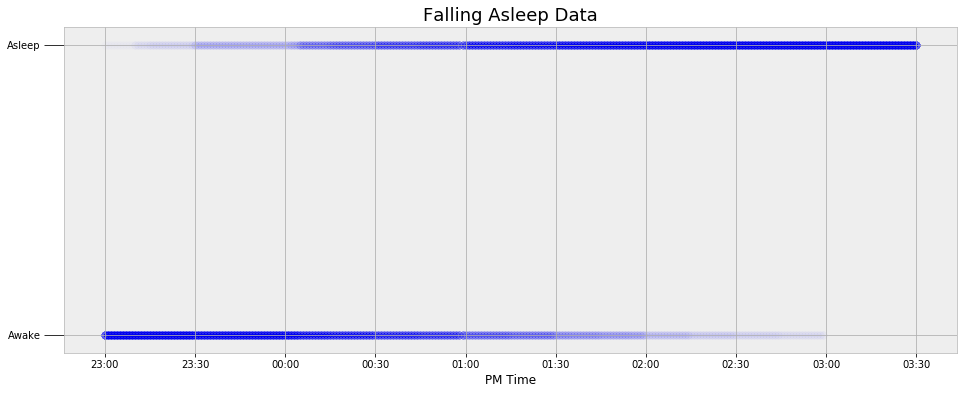

In [3]:
figsize(16, 6)
# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['Indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); 
plt.title('Falling Asleep Data', size = 18)
plt.xticks(np.linspace(sleep_data.time_offset.min(), sleep_data.time_offset.max(), len(sleep_labels)), sleep_labels);
plt.savefig("Fallingasleep.png")

# Wake Data をダウンロード、そして可視化

In [4]:
wake_data = pd.read_csv('wake_data.csv')

In [5]:
wake_data.head()

,Indicator,time_offset,time_range
0,1,-120.0,2019-07-01 06:00:00
1,1,-119.0,2019-07-01 06:01:00
2,1,-118.0,2019-07-01 06:02:00
3,1,-117.0,2019-07-01 06:03:00
4,1,-116.0,2019-07-01 06:04:00


In [6]:
wake_labels = ['6:00', '6:30', '7:00', '7:30', '8:00', '8:30', '9:00', '9:30',
               '10:00', '10:30', '11:00', '11:30', '12:00', '12:30']

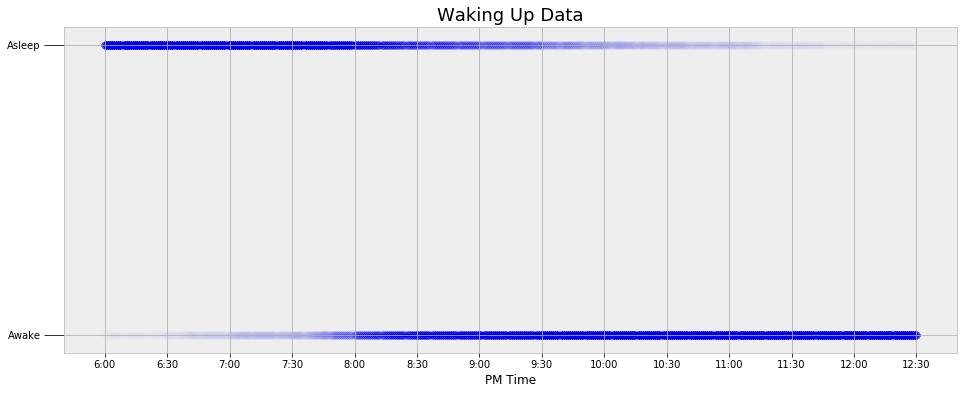

In [7]:
figsize(16, 6)
# Sleep data
plt.scatter(wake_data['time_offset'], wake_data['Indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); 
plt.title('Waking Up Data', size = 18)
plt.xticks(np.linspace(wake_data.time_offset.min(), wake_data.time_offset.max(), len(wake_labels)), wake_labels);
plt.savefig('wake_up.png')

## 事前分布として用いる正規分布

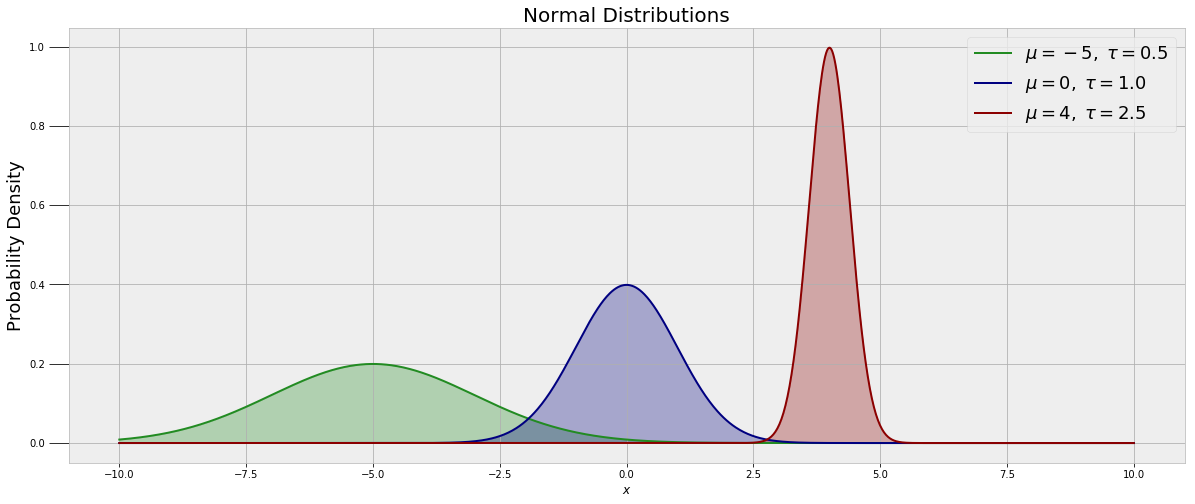

In [8]:
figsize(20, 8)
# Set up the plotting parameters
nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("forestgreen", "navy", "darkred")

# Plot 3 pdfs for different normal distributions
params = zip(mu, tau, colors)
for param in params:
    y = nor.pdf(x, loc = param[0], scale = 1 / param[1])
    plt.plot(x, y, 
             label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), 
             color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
    
plt.legend(prop={'size':18});
plt.xlabel("$x$")
plt.ylabel("Probability Density", size = 18)
plt.title("Normal Distributions", size = 20);

## 確率分布を表すシグモイド関数

(-2, -2, 'forestgreen')
(-5, 1, 'navy')
(1, -1, 'darkred')


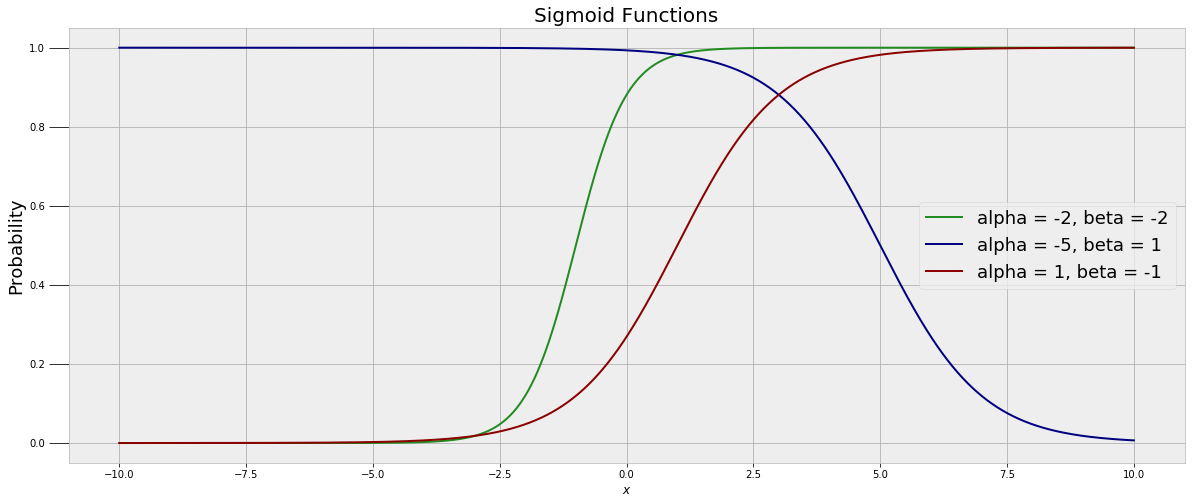

In [9]:
figsize(20, 8)
# Set up the plotting parameters
nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("forestgreen", "navy", "darkred")

alpha = (-2, -5, 1)
beta = (-2, 1, -1)


# Plot 3 pdfs for different normal distributions
params = zip(alpha, beta, colors)
for param in params:
    print(param)
    alpha = param[0]
    beta = param[1]
    y = 1 / (1 + np.exp(alpha + beta*x))
    plt.plot(x, y, 
             label= f"alpha = {param[0]}, beta = {param[1]}", 
             color = param[2])
    
plt.legend(prop={'size':18});
plt.xlabel("$x$")
plt.ylabel("Probability", size = 18)
plt.title("Sigmoid Functions", size = 20);
plt.savefig("sigmoid.png")

# pymc3 model

### まずは就寝データにモデルを

In [10]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'Indicator'])

In [11]:
with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed dat
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step)
    #trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:41<00:00, 265.13draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:

# Extract the alpha and beta samples
alpha_samples = sleep_trace["alpha"][5000:, None]
beta_samples = sleep_trace["beta"][5000:, None]

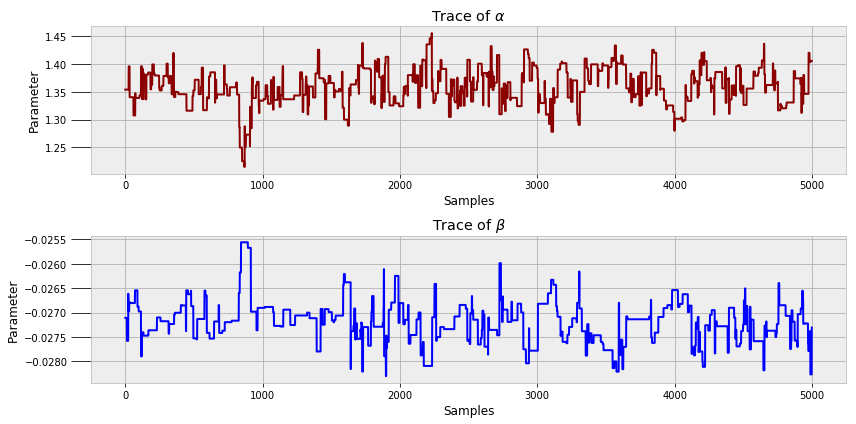

In [13]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

### alpha と betaの分布を出してみる

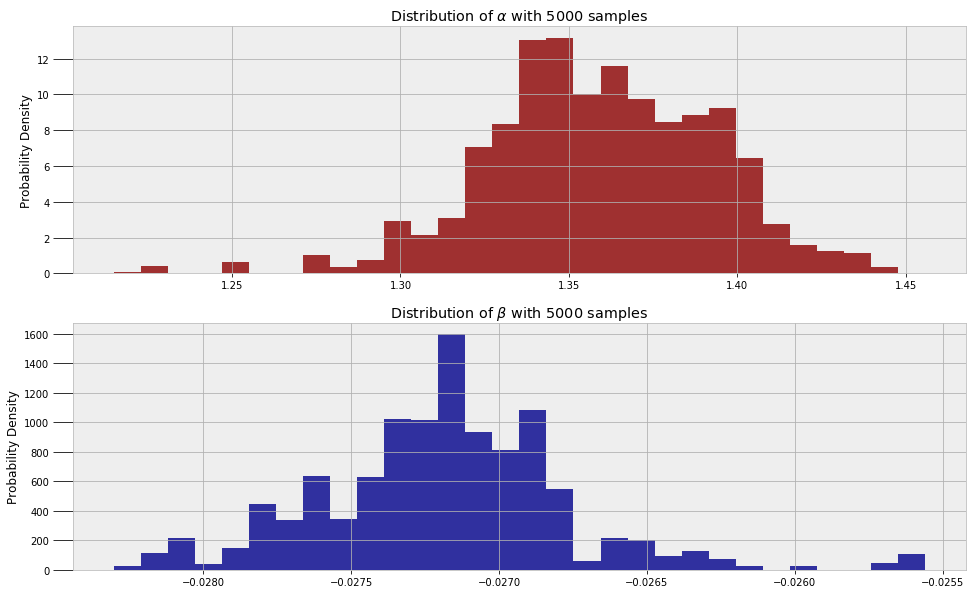

In [14]:
figsize(16, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

In [15]:
# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1e3)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

### 推定したalpha と betaを使ってLogistic 関数を可視化

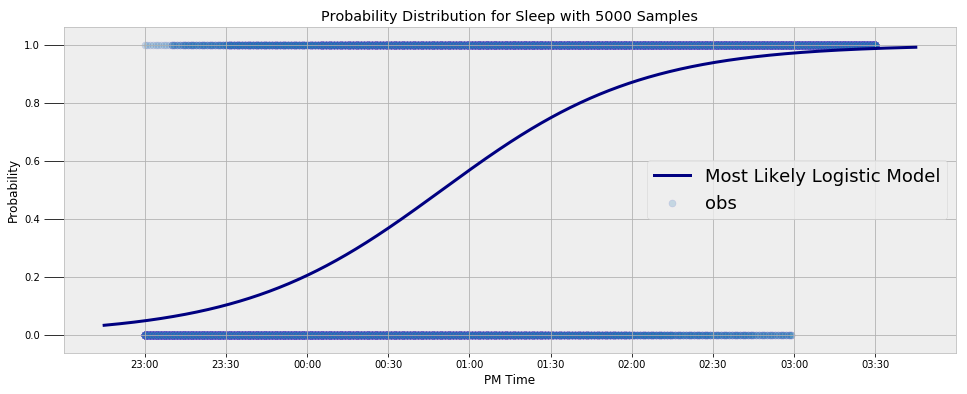

In [17]:
figsize(16, 6)

plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="Most Likely Logistic Model")
plt.scatter(time, sleep_obs, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title('Probability Distribution for Sleep with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('Probability')
plt.xlabel('PM Time');
plt.xticks(np.linspace(sleep_data.time_offset.min(), sleep_data.time_offset.max(), 10), sleep_labels);
plt.savefig("sleep_prob_dist")

In [18]:
print(f"The probabiity of sleep increases to above 50% at "
      f"0:{int(time_est[np.where(sleep_est > 0.5)[0][0]][0])} PM.")

The probabiity of sleep increases to above 50% at 0:50 PM.


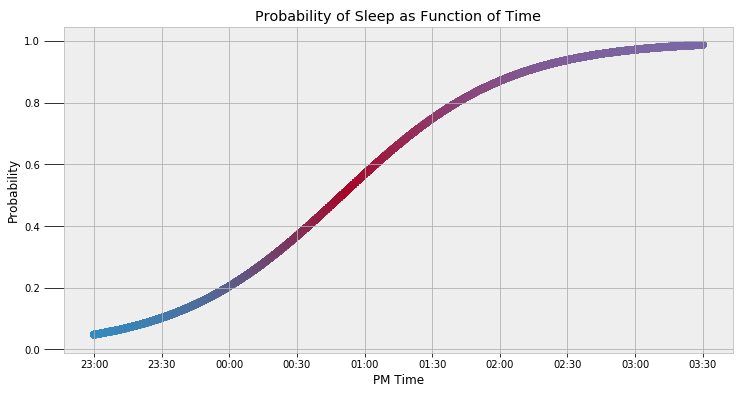

In [20]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = sleep_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Sleep as Function of Time')
plt.xlabel('PM Time');
plt.ylabel('Probability');
plt.xticks(np.linspace(sleep_data.time_offset.min(), sleep_data.time_offset.max(), len(sleep_labels)), sleep_labels);

In [21]:
print('00:00 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(0, beta_est, alpha_est)))
print('23:30  PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(-30, beta_est, alpha_est)))
print('00:30 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(30, beta_est, alpha_est)))

00:00 PM probability of being asleep: 20.44%.
23:30  PM probability of being asleep: 10.20%.
00:30 PM probability of being asleep: 36.74%.


In [22]:
print(f'11:30 PM probability of being asleep: {round(100 * logistic(-30, beta_est, alpha_est))} %')
print(f'00:00 PM probability of being asleep: {round(100 * logistic(0, beta_est, alpha_est))} %')
print(f'00:30 PM probability of being asleep: {round(100 * logistic(30, beta_est, alpha_est))} %')
print(f'00:50 PM probability of being asleep: {round(100 * logistic(50, beta_est, alpha_est))} %')

11:30 PM probability of being asleep: 10.0 %
00:00 PM probability of being asleep: 20.0 %
00:30 PM probability of being asleep: 37.0 %
00:50 PM probability of being asleep: 50.0 %


In [23]:
print(f'01:30 PM probability of being asleep: {round(100 * logistic(90, beta_est, alpha_est))} %')

01:30 PM probability of being asleep: 75.0 %


In [24]:
sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = stats.mstats.mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

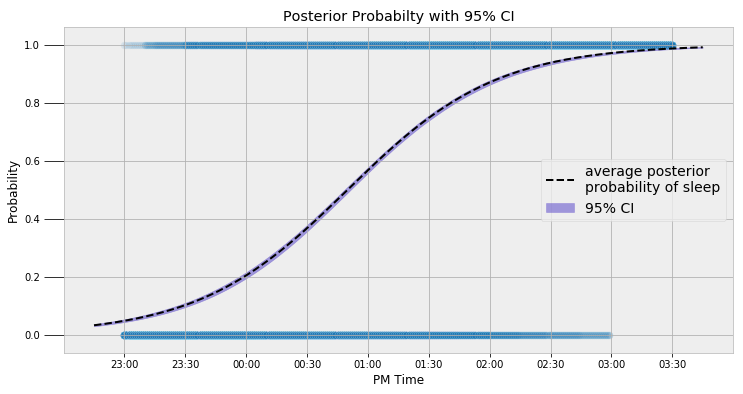

In [25]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, 
                 color='slateblue', label = '95% CI')
plt.plot(time_est, sleep_est, lw=2, ls='--', 
         color='black', label="average posterior \nprobability of sleep")
plt.xticks(np.linspace(sleep_data.time_offset.min(), sleep_data.time_offset.max(), 10), sleep_labels);
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('PM Time'); plt.ylabel('Probability'); 
plt.title('Posterior Probabilty with 95% CI');

## 起床時間のモデル

In [26]:
# Sort the values by time offset
wake_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(wake_data.loc[:, 'time_offset'])

# Observations are the indicator
wake_obs = np.array(wake_data.loc[:, 'Indicator'])

with pm.Model() as wake_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    wake_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:59<00:00, 170.46draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [27]:
# Extract the alpha and beta samples
alpha_samples = wake_trace["alpha"][5000:, None]
beta_samples = wake_trace["beta"][5000:, None]

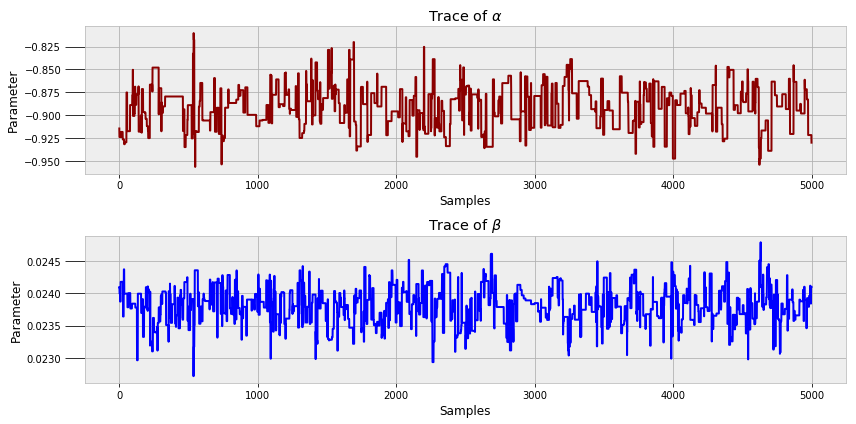

In [28]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

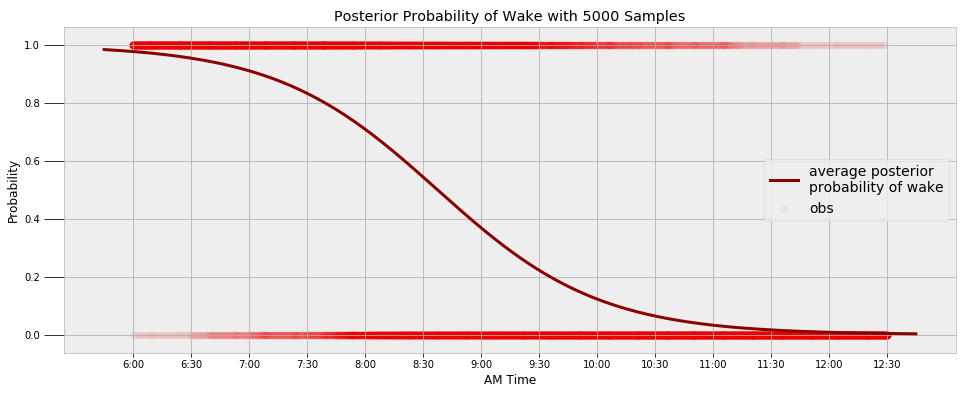

In [29]:
# Extract the alpha and beta samples
alpha_samples = wake_trace["alpha"][5000:, None]
beta_samples = wake_trace["beta"][5000:, None]

# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1e3)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
wake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

figsize(16, 6)

plt.plot(time_est, wake_est, color = 'darkred', 
         lw=3, label="average posterior \nprobability of wake")
plt.scatter(time, wake_obs, edgecolor = 'r', facecolor = 'r', 
            s=50, alpha=0.05, label='obs')
plt.title('Posterior Probability of Wake with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probability')
plt.xlabel('AM Time');
plt.xticks(np.linspace(wake_data.time_offset.min(), wake_data.time_offset.max(), len(wake_labels)), wake_labels);
plt.savefig("wake_posterior.png")

In [30]:
print('The probability of being awake passes 50% at 6:{} AM.'.format(int(time_est[np.where(wake_est < 0.5)][0])))

The probability of being awake passes 50% at 6:37 AM.


In [31]:
np.where(sleep_est > 0.5)[0][0]

417

In [32]:
print(f"Probability of being awake at 7:30 AM: {round(100 - (100 * logistic(-30, beta=beta_est, alpha=alpha_est)))} %")
print(f"Probability of being awake at 8:00 AM: {round(100 - (100 * logistic(0, beta=beta_est, alpha=alpha_est)))} %")
print(f"Probability of being awake at 8:30 AM: {round(100 - (100 * logistic(30, beta=beta_est, alpha=alpha_est)))} %")
print(f"Probability of being awake at 9:00 AM: {round(100 - (100 * logistic(60, beta=beta_est, alpha=alpha_est)))} %")
print(f"Probability of being awake at 9:30 AM: {round(100 - (100 * logistic(90, beta=beta_est, alpha=alpha_est)))} %")

Probability of being awake at 7:30 AM: 17.0 %
Probability of being awake at 8:00 AM: 29.0 %
Probability of being awake at 8:30 AM: 46.0 %
Probability of being awake at 9:00 AM: 63.0 %
Probability of being awake at 9:30 AM: 78.0 %


## 睡眠時間の長さのモデル

In [33]:
raw_data = pd.read_csv('sleep_wake.csv', index_col=0)

In [34]:
raw_data.head()

,Date,Sleep,Wake,length
0,2019/7/1,-5.0,55.0,7.000000
1,2019/7/2,30.0,20.0,8.166667
2,2019/7/3,-95.0,15.0,6.166667
3,2019/7/4,-2.0,10.0,7.800000
4,2019/7/5,-5.0,-5.0,8.000000


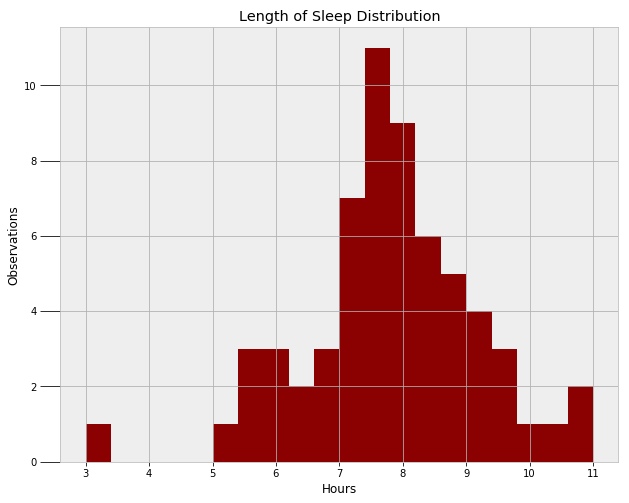

In [45]:
duration = raw_data['length']

figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred')
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution'); 
plt.ylabel('Observations');
plt.savefig("sleeptime.png")

## 寝溜めのほうが早起きより多いことから、right skewのpdfでフィット

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


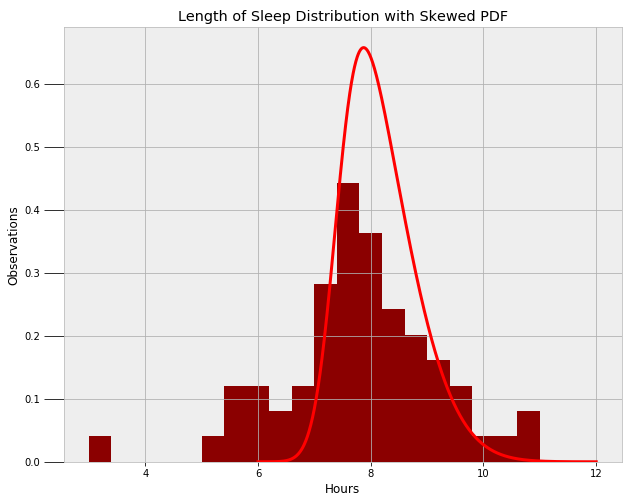

In [36]:
a = 3
fig, ax = plt.subplots(1, 1)
x = np.linspace(6, 12, 1e3)


figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred', normed=True)
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution with Skewed PDF'); 
plt.ylabel('Observations');
plt.plot(x, stats.skewnorm.pdf(x, a, loc = 7.4, scale=1), 'r-', 
         lw=3, label='skewnorm pdf');
plt.savefig("skew.png")

In [37]:
with pm.Model() as duration_model:
    # Three parameters to sample
    alpha_skew = pm.Normal('alpha_skew', mu=0, tau=0.5, testval=3.0)
    mu_ = pm.Normal('mu', mu=0, tau=0.5, testval=7.4)
    tau_ = pm.Normal('tau', mu=0, tau=0.5, testval=1.0)
    
    # Duration is a deterministic variable
    duration_ = pm.SkewNormal('duration', alpha = alpha_skew, mu = mu_, 
                              sd = 1/tau_, observed = duration)
    
    # Metropolis Hastings for sampling
    step = pm.Metropolis()
    duration_trace = pm.sample(N_SAMPLES, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [mu]
>Metropolis: [alpha_skew]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:06<00:00, 1653.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [38]:
# Extract the most likely estimates from the sampling
alpha_skew_samples = duration_trace['alpha_skew'][5000:]
mu_samples = duration_trace['mu'][5000:]
tau_samples = duration_trace['tau'][5000:]

alpha_skew_est = alpha_skew_samples.mean()
mu_est = mu_samples.mean()
tau_est = tau_samples.mean()

### 最終的な睡眠時間の分布

The most likely duration of sleep is 7.56 hours.


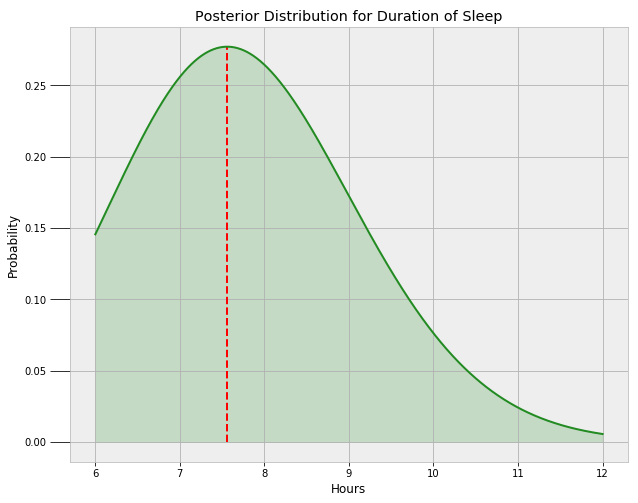

In [39]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
plt.plot(x, y, color = 'forestgreen')
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);
plt.xlabel('Hours'); plt.ylabel('Probability'); 
plt.title('Posterior Distribution for Duration of Sleep');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='red', 
           label = 'Most Likely Duration');

print('The most likely duration of sleep is {:.2f} hours.'.format(x[np.argmax(y)]))
plt.savefig("posterior_sleep_dist.png")

In [47]:
duration_lis = [6.5, 8.0, 9.0]

for dur in duration_lis:
    prob = round(100 * (1 - stats.skewnorm.cdf(dur, a = alpha_skew_est,
                                               loc = mu_est, scale = 1 / tau_est)))
    print(f"Probability of at least {dur} hours of sleep: "
          f"{prob}")

Probability of at least 6.5 hours of sleep: 79.0
Probability of at least 8.0 hours of sleep: 41.0
Probability of at least 9.0 hours of sleep: 18.0


In [41]:
print('Probability of at least 6.5 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(6.5, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probability of at least 8.0 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(8.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probability of at least 9.0 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(9.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))

Probability of at least 6.5 hours of sleep = 79.48%.
Probability of at least 8.0 hours of sleep = 40.69%.
Probability of at least 9.0 hours of sleep = 18.41%.


### モデルと観測値の比較

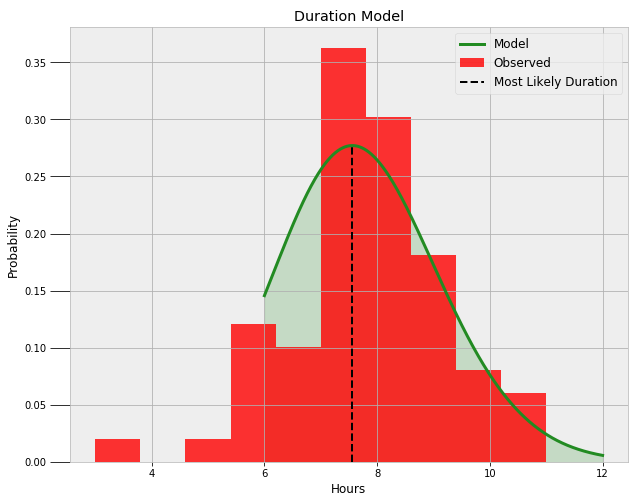

In [48]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
figsize(10, 8)
# Plot the posterior distribution
plt.plot(x, y, color = 'forestgreen', 
         label = 'Model', lw = 3)
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);

# Plot the observed values
plt.hist(duration, bins=10, color = 'red', alpha=0.8,
         label='Observed', normed=True)
plt.xlabel('Hours'); plt.ylabel('Probability'); 
plt.title('Duration Model');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='k', 
           label = 'Most Likely Duration');
plt.legend(prop={'size':12});